In [1]:
import os

datadir = "/home/ymerel/fmri/OHBM_2026_neurovariants/data/emotion_1000"
ds_path = os.path.join(datadir, 'dataset.csv')
corr_path = os.path.join(datadir, 'correlations.csv')
corr_func = 'spearman'
basedir = "/home/ymerel/storage/results/"
jobname = "emotion_1000"
result_path = f"{basedir}{jobname}"
coords = [0, -6, -16]

In [2]:
!sshfs -o reconnect,ServerAliveInterval=120,ServerAliveCountMax=3 rennes.g5k:/srv/storage/empenn@storage2.rennes.grid5000.fr/private/ymerel /home/ymerel/storage

fusermount3: failed to access mountpoint /home/ymerel/storage: Permission denied


In [3]:
import pandas as pd

def normalize_dataset(ds: pd.DataFrame):
    
    str_alternatives = {
        "motion_correction_realignment/register_to" : ["first", "mean"],
        "coregistration/source_target" : ["anat_on_func", "func_on_anat"],
        "coregistration/cost_function" : ["mutual_information", "normalised_mutual_information", "entropy_correlation_coefficient", "normalised_cross_correlation"],
        "spatial_normalization/template" : ["Ixi549Space", "MNI305", "MNI152_linear", "MNI152_nonlinear"],
        "spatial_normalization/algorithm" : ["linear", "nonlinear", "DARTEL"],
        "spatial_normalization/interpolation" : ["nearest_neighbour", "trilinear", "bspline"],
        "slice_timing_correction/ref_slice" : ["first", "middle"],
        "signal_modeling/hrf" : ["canonical", "temporal_derivs", "temporal_dispersion_derivs"],
        "signal_modelling/temporal_noise_autocorrelation" : ["AR1", "FAST"],
    }

    num_alternatives = {
        "spatial_normalization/bias_fwhm" : [30, 40, 60, 70, 80, 90, 100, 110, 120,130,140,150],
        "spatial_smoothing/fwhm" : [2, 4, 6, 8, 10, 12, 14],
        "signal_modeling/nuisance_regressors/motion" : [6, 18, 24]
    }
    
    bias_regs = {
            'extremely_light': 0.00001,
            'very_light': 0.0001,
            'light': 0.001,
            'medium': 0.01,
            'heavy': 0.1
        }
    
    # change column types
    for col in num_alternatives:
        ds[col] = ds[col].astype(int)
    for col in bias_regs:
        ds[f"spatial_normalization/bias_regularisation/{col}"] = ds[f"spatial_normalization/bias_regularisation/{col}"].astype(float)
    
    for index, row in ds.iterrows():
        for feature, values in num_alternatives.items():
            if row[feature] is False:
                ds.at[index, feature] = 0
                continue
            for val in values:
                alt = f"{feature}/{val}"
                if row[alt] is True:
                    ds.at[index, feature] = val
        for label, value in bias_regs.items():
            if row[f"spatial_normalization/bias_regularisation/{label}"] is True:
                ds.at[index, "spatial_normalization/bias_regularisation"] = value
    
    for key in num_alternatives:
        for val in num_alternatives[key]:
            ds = ds.drop(f"{key}/{val}",  axis=1)
    ds = ds.convert_dtypes()
    boolean_columns = ds.select_dtypes(include='bool').columns
    columns_to_drop = [col for col in boolean_columns if ds[col].all()]
    ds = ds.drop(columns=columns_to_drop)
    return ds

# Load data

In [4]:
# load correlations
correlations = pd.read_csv(corr_path, delimiter=';')
matrix = correlations.pivot(index='source', columns='target', values=corr_func).fillna(1.0)
distance_matrix = 1 - matrix

dataset = pd.read_csv(ds_path, delimiter=';')
dataset = normalize_dataset(dataset)

dataset.head(20)

,coregistration/source_target/func_on_anat,signal_modeling/nuisance_regressors,motion_correction_realignment/register_to/mean,coregistration/cost_function/normalised_mutual_information,motion_correction_realignment/register_to/first,signal_modelling/temporal_noise_autocorrelation/FAST,spatial_normalization/template/MNI152_linear,spatial_normalization/interpolation/trilinear,spatial_normalization/template/MNI305,spatial_normalization/algorithm/linear,...,spatial_normalization/interpolation/bspline,spatial_normalization/bias_regularisation/heavy,slice_timing_correction,slice_timing_correction/tool/spm,slice_timing_correction/ref_slice/first,coregistration/source_target/anat_on_func,spatial_normalization/template/MNI152_nonlinear,id,from_ref,from_mean
0,False,True,True,True,False,False,False,False,False,False,...,True,0,True,True,False,True,False,3c05066eec67a15033be163c0f9ff11b5c10fd45cd65ba...,1.0,0.934228
1,True,True,False,True,True,False,False,False,False,False,...,False,0,False,False,False,False,False,77d25bad1f58f2375fad132526338feec5fa20a007412d...,0.905479,0.917162
2,True,True,False,True,True,False,False,False,False,False,...,False,0,False,False,False,False,False,1284fe154b24f80e1dbeff397c39ef48b298e7093e793f...,0.946033,0.936825
3,False,True,False,True,True,False,False,True,False,False,...,False,0,False,False,False,True,False,65985debeaca69ce587a38dd194dd322f5f44cc7211fe2...,0.946033,0.936825
4,True,False,False,True,True,True,False,False,False,False,...,False,0,False,False,False,False,False,f55a803f4a3a8bdef038d07ceeadc30109ff446526558c...,0.946033,0.936825
5,True,True,False,True,True,False,False,False,False,False,...,False,0,False,False,False,False,False,1c3534517d0d1a0bc2a4ace8d50f1ec35e27b1d8f1a76c...,0.946033,0.936825
6,False,False,False,True,True,True,False,False,False,False,...,False,0,False,False,False,True,False,023f04fac611061bd8904d53f3bfdb9d5e137904a126e0...,0.946033,0.936825
7,False,True,False,True,True,False,False,True,False,False,...,False,0,False,False,False,True,False,43f186995d5205fb63d8ef676cbb475b9ed50d81af7c37...,0.946033,0.936825
8,False,True,False,True,True,True,False,True,False,False,...,False,0,False,False,False,True,False,00d978fce6dbfdcae93feb84d97dffa6cf46080035faba...,0.946033,0.936825
9,True,True,False,True,True,True,False,False,False,False,...,True,0,False,False,False,False,False,4a21e2fe7bb1fef24afe6849dfb5617bdc5555cd2538b4...,0.946033,0.936825


# Compare correlations metrics
Evaluate distribution of values for Pearson, spearman, jaccard, dice
Compare Pearson vs Spearman

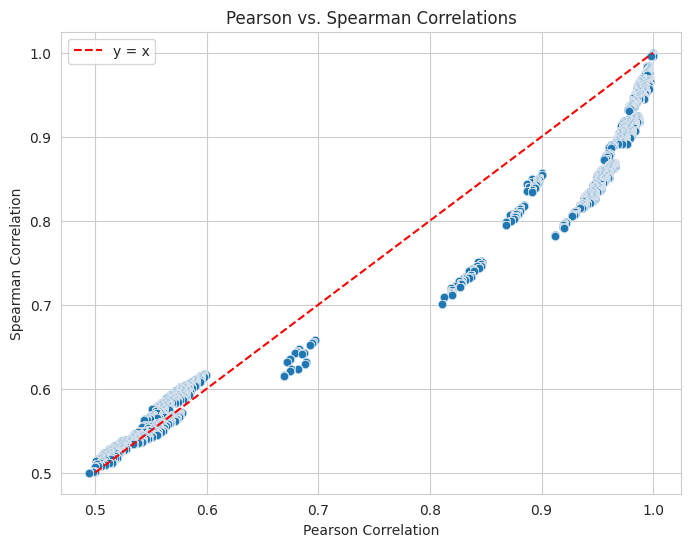

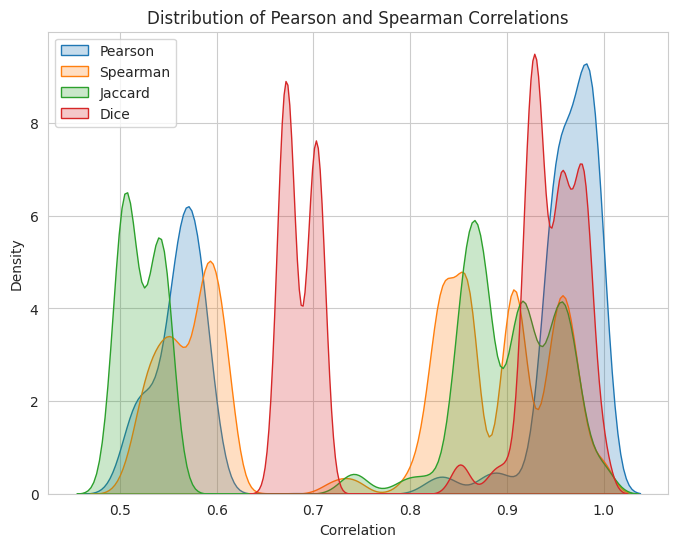

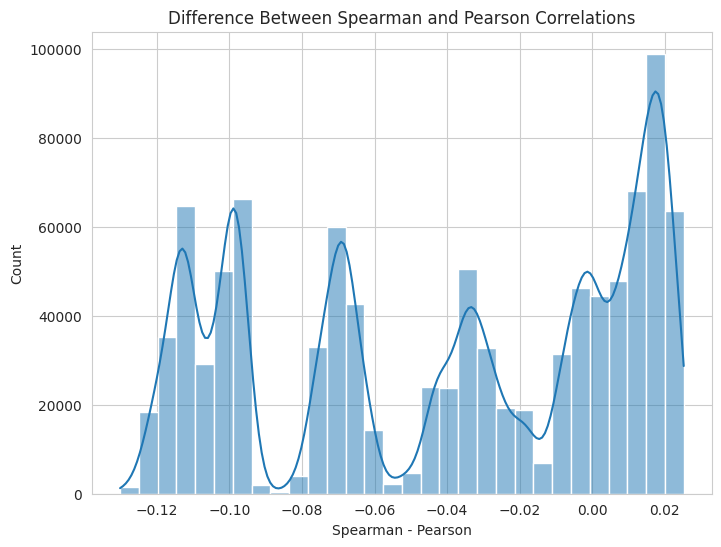

In [5]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize=(8, 6))
sb.scatterplot(data=correlations, x="pearson", y="spearman", alpha=0.5)
plt.plot([0.5, 1], [0.5, 1], 'r--', label="y = x")  # Diagonal line
plt.xlabel("Pearson Correlation")
plt.ylabel("Spearman Correlation")
plt.title("Pearson vs. Spearman Correlations")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sb.kdeplot(data=correlations, x="pearson", label="Pearson", fill=True)
sb.kdeplot(data=correlations, x="spearman", label="Spearman", fill=True)
sb.kdeplot(data=correlations, x="jaccard", label="Jaccard", fill=True)
sb.kdeplot(data=correlations, x="dice", label="Dice", fill=True)
plt.xlabel("Correlation")
plt.ylabel("Density")
plt.title("Distribution of Pearson and Spearman Correlations")
plt.legend()
plt.show()

correlations["difference"] = correlations["spearman"] - correlations["pearson"]

plt.figure(figsize=(8, 6))
sb.histplot(data=correlations, x="difference", bins=30, kde=True)
plt.xlabel("Spearman - Pearson")
plt.ylabel("Count")
plt.title("Difference Between Spearman and Pearson Correlations")
plt.show()

# Clusterize

## Hierachical cluster methods

In [6]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster._optimal_leaf_ordering import squareform
from scipy.cluster.hierarchy import fcluster

def clusterize_hierch(dataset: pd.DataFrame, ids: list, nb_clusters, metric: str, threshold=0.2):
    """
    
    :param dataset: DataFrame
    :param ids: list of configs ids
    :param nb_clusters: 
    :param metric: 'spearman', 'dice', jaccard'
    :return: 
    """
    
    filtered_ds = dataset[dataset['id'].isin(ids)].copy()
    filtered_corr = correlations[correlations['source'].isin(ids) & correlations['target'].isin(ids)].copy()
    filtered_matrix = filtered_corr.pivot(index='source', columns='target', values=metric).fillna(1.0)
    filtered_distance_matrix = 1 - filtered_matrix
    
    Z = linkage(squareform(filtered_distance_matrix), method='complete')
    
    if nb_clusters is not None:
        clusters = fcluster(Z, nb_clusters, criterion='maxclust')
    else:
        clusters = fcluster(Z, t=threshold, criterion='distance')
    
    matrix_df = pd.DataFrame(filtered_distance_matrix)
    matrix_df['cluster'] = clusters
    cluster_centroids = matrix_df.groupby('cluster').mean().mean(axis=1)
    sorted_clusters = cluster_centroids.sort_values().index
    consistent_label_mapping = {old_label: new_label + 1 for new_label, old_label in enumerate(sorted_clusters)}
    consistent_clusters = matrix_df['cluster'].map(consistent_label_mapping)

    mapping = pd.DataFrame({'config': filtered_distance_matrix.index, 'cluster': consistent_clusters})
    for id, row in mapping.iterrows():
        config = row['config']
        cluster = row['cluster']
        filtered_ds.loc[filtered_ds['id'] == config, 'cluster'] = int(cluster)
        
    filtered_ds = filtered_ds.sort_values(by='id', ascending=False)
    return filtered_ds, filtered_matrix, Z, consistent_clusters

## Cluster prediction methods

In [7]:
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree

def predict_clusters(dataset, nb_clusters, threshold= 0.2, train_size=0.7):
    
    results = dict()
    results['train_size'] = train_size
    
    ignored = [col for col in dataset.columns if col.startswith('from_')]
    ignored.append('id')
    ignored.append('cluster')
    
    X = dataset['id']
    y = dataset['id']
    
    X_id_train, X_id_test, y_id_train, y_id_test = train_test_split(X, y, train_size=train_size, random_state=42)
    
    if nb_clusters is not None:
        ds_train, matrix, Z, clusters = clusterize_hierch(dataset, X_id_train, nb_clusters, corr_func)
    else:
        ds_train, matrix, Z, clusters = clusterize_hierch(dataset, X_id_train, None, corr_func, threshold)
    
    y_train = ds_train['cluster']
    target_names = [str(name) for name in y_train.unique()]
    X_train = ds_train.drop(columns=ignored)
    
    if nb_clusters is not None:
        ds_test, _, _, _ = clusterize_hierch(dataset, X_id_test, nb_clusters, corr_func)
    else:
        ds_test, _, _, _ = clusterize_hierch(dataset, X_id_test, None, corr_func, threshold)
    y_test = ds_test['cluster']
    X_test = ds_test.drop(columns=ignored)

    classifier = DecisionTreeClassifier(random_state=42)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    target_names = [str(name) for name in y_test.unique()]
    report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True, zero_division=0)
    
    results['accuracy'] = report['accuracy']
    results['recall'] = report['macro avg']['recall']
    
    # decision tree
    results['decision_tree'] = tree.export_graphviz(classifier, out_file=None,
                                             feature_names=X_train.columns.values,
                                             filled=True, rounded=True,
                                             special_characters=True,
                                             leaves_parallel=True, proportion=True)
    
    # feature importances
    features = ds_train.drop(columns=ignored).columns
    importances = classifier.feature_importances_
    feat_importances = dict()
    for i, feat in enumerate(features):
        if importances[i] > 0.0:
            feat_importances[feat] = importances[i]
    results['feature_importances'] = feat_importances
    
    return results

## Cluster by cluster number

In [8]:
import numpy as np
from utils import get_cluster_distance_densities, get_cluster_cophenetic, get_cluster_silhouette, get_davies_bouldin, \
    get_cluster_inertia, get_medoids

all_results = []

nb_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for nb in nb_clusters:
    
    results = dict()
    
    results['clusters'] = nb
    results['threshold'] = None
    
    # cluster on whole dataset
    ds, matrix, Z, clusters = clusterize_hierch(dataset, dataset['id'], nb, corr_func)
    
    distance_matrix = 1 - matrix
    densities = get_cluster_distance_densities(distance_matrix.values, clusters.values)
    results['mean_density'] = np.mean(list(densities.values()))
    results['cophenetic'] = get_cluster_cophenetic(Z, distance_matrix.values)
    results['silhouette'] = get_cluster_silhouette(distance_matrix.values, clusters.values)
    results['davies_bouldin'] = get_davies_bouldin(distance_matrix.values, clusters.values)
    results['inertia'] = get_cluster_inertia(distance_matrix.values, clusters.values)
    results['medoids'] = get_medoids(distance_matrix, clusters)
    
    # predict on 70 % train dataset
    merged_results = results | predict_clusters(dataset, nb)
    all_results.append(merged_results)

df_by_nb = pd.DataFrame(all_results)
df_by_nb.head(10)

,clusters,threshold,mean_density,cophenetic,silhouette,davies_bouldin,inertia,medoids,train_size,accuracy,recall,decision_tree,feature_importances
0,2,None,0.133914,0.990618,0.725031,0.275325,9407.513048,{1: '39e6bf7b4ae0f339043540c5c6ef79c40c15d8b4c...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/normalised_cros...
1,3,None,0.111240,0.990618,0.683959,0.635573,7789.057571,{1: '39e6bf7b4ae0f339043540c5c6ef79c40c15d8b4c...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/normalised_cros...
2,4,None,0.082237,0.990618,0.681087,0.495763,7668.650545,{1: '39e6bf7b4ae0f339043540c5c6ef79c40c15d8b4c...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/me...
3,5,None,0.066609,0.990618,0.726028,0.451320,7237.345646,{1: '39e6bf7b4ae0f339043540c5c6ef79c40c15d8b4c...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/fi...
4,6,None,0.059157,0.990618,0.614747,0.496896,1557.092508,{1: '32b68c5ab087b2ecc92976393a936cb0b95026ad9...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/me...
5,7,None,0.052696,0.990618,0.593646,0.458147,620.157727,{1: '9111a94c1a55f876b2a92dfa6466af0879e5b3487...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/me...
6,8,None,0.044870,0.990618,0.596779,0.403585,584.745281,{1: '9111a94c1a55f876b2a92dfa6466af0879e5b3487...,0.7,0.886667,0.750000,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/me...
7,9,None,0.035881,0.990618,0.604614,0.347636,575.332045,{1: '9111a94c1a55f876b2a92dfa6466af0879e5b3487...,0.7,0.886667,0.777778,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/me...
8,10,None,0.032197,0.990618,0.627666,0.350519,349.047698,{1: '9111a94c1a55f876b2a92dfa6466af0879e5b3487...,0.7,0.886667,0.800000,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/me...


## Cluster by threshold

In [9]:
all_results = []

thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]

for threshold in thresholds:
    results = dict()
    results['threshold'] = threshold
    # cluster on whole dataset
    ds, matrix, Z, clusters = clusterize_hierch(dataset, dataset['id'], None, corr_func, threshold)
    results['clusters'] = len(np.unique(clusters.values)) 
    
    distance_matrix = 1 - matrix
    densities = get_cluster_distance_densities(distance_matrix.values, clusters.values)
    results['mean_density'] = np.mean(list(densities.values()))
    results['cophenetic'] = get_cluster_cophenetic(Z, distance_matrix.values)
    results['silhouette'] = get_cluster_silhouette(distance_matrix.values, clusters.values)
    results['davies_bouldin'] = get_davies_bouldin(distance_matrix.values, clusters.values)
    results['inertia'] = get_cluster_inertia(distance_matrix.values, clusters.values)
    results['medoids'] = get_medoids(distance_matrix, clusters)
        
    # predict on 70 % train dataset
    merged_results = results | predict_clusters(dataset, None, threshold, 0.7)
    all_results.append(merged_results)

df_by_thresh = pd.DataFrame(all_results)
df_by_thresh.head(10)

,threshold,clusters,mean_density,cophenetic,silhouette,davies_bouldin,inertia,medoids,train_size,accuracy,recall,decision_tree,feature_importances
0,0.05,19,0.019597,0.990618,0.526479,0.770410,58.716719,{2: 'efd854c97520d876d11dbbc60711b535a9ac916e7...,0.7,0.82,0.789474,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/me...
1,0.10,12,0.023362,0.990618,0.644229,0.306353,314.045380,{1: '9111a94c1a55f876b2a92dfa6466af0879e5b3487...,0.7,0.95,0.833333,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/me...
2,0.15,6,0.059157,0.990618,0.614747,0.496896,1557.092508,{1: '32b68c5ab087b2ecc92976393a936cb0b95026ad9...,0.7,1.00,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/me...
3,0.20,5,0.066609,0.990618,0.726028,0.451320,7237.345646,{1: '39e6bf7b4ae0f339043540c5c6ef79c40c15d8b4c...,0.7,1.00,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/fi...
4,0.25,3,0.111240,0.990618,0.683959,0.635573,7789.057571,{1: '39e6bf7b4ae0f339043540c5c6ef79c40c15d8b4c...,0.7,1.00,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/normalised_cros...
5,0.30,2,0.133914,0.990618,0.725031,0.275325,9407.513048,{1: '39e6bf7b4ae0f339043540c5c6ef79c40c15d8b4c...,0.7,1.00,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/normalised_cros...
6,0.35,2,0.133914,0.990618,0.725031,0.275325,9407.513048,{1: '39e6bf7b4ae0f339043540c5c6ef79c40c15d8b4c...,0.7,1.00,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/normalised_cros...


## Print all metrics
- Cophenetic correlation: > 0.75 = good ; < 0.75 = poor
- Silhouette score: -1 = worst ; 1 = best
- Davies-Bouldin index: < 1 = good
- Inertia: lower = tighter

In [10]:
df_results = pd.concat([df_by_nb, df_by_thresh], axis=0)
df_results.head(20)

/home/ymerel/tmp/ipykernel_114376/3439721280.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_by_nb, df_by_thresh], axis=0)


,clusters,threshold,mean_density,cophenetic,silhouette,davies_bouldin,inertia,medoids,train_size,accuracy,recall,decision_tree,feature_importances
0,2,NaN,0.133914,0.990618,0.725031,0.275325,9407.513048,{1: '39e6bf7b4ae0f339043540c5c6ef79c40c15d8b4c...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/normalised_cros...
1,3,NaN,0.111240,0.990618,0.683959,0.635573,7789.057571,{1: '39e6bf7b4ae0f339043540c5c6ef79c40c15d8b4c...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/normalised_cros...
2,4,NaN,0.082237,0.990618,0.681087,0.495763,7668.650545,{1: '39e6bf7b4ae0f339043540c5c6ef79c40c15d8b4c...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/me...
3,5,NaN,0.066609,0.990618,0.726028,0.451320,7237.345646,{1: '39e6bf7b4ae0f339043540c5c6ef79c40c15d8b4c...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/fi...
4,6,NaN,0.059157,0.990618,0.614747,0.496896,1557.092508,{1: '32b68c5ab087b2ecc92976393a936cb0b95026ad9...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/me...
5,7,NaN,0.052696,0.990618,0.593646,0.458147,620.157727,{1: '9111a94c1a55f876b2a92dfa6466af0879e5b3487...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/me...
6,8,NaN,0.044870,0.990618,0.596779,0.403585,584.745281,{1: '9111a94c1a55f876b2a92dfa6466af0879e5b3487...,0.7,0.886667,0.750000,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/me...
7,9,NaN,0.035881,0.990618,0.604614,0.347636,575.332045,{1: '9111a94c1a55f876b2a92dfa6466af0879e5b3487...,0.7,0.886667,0.777778,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/me...
8,10,NaN,0.032197,0.990618,0.627666,0.350519,349.047698,{1: '9111a94c1a55f876b2a92dfa6466af0879e5b3487...,0.7,0.886667,0.800000,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/me...
0,19,0.05,0.019597,0.990618,0.526479,0.770410,58.716719,{2: 'efd854c97520d876d11dbbc60711b535a9ac916e7...,0.7,0.820000,0.789474,"digraph Tree {\nnode [shape=box, style=""filled...",{'motion_correction_realignment/register_to/me...


## Identify incorrect clusters by medoids

Cluster [1] - Medoids [39e6bf7b4ae0f339043540c5c6ef79c40c15d8b4c71c82f4258bb4e2aac593f0]


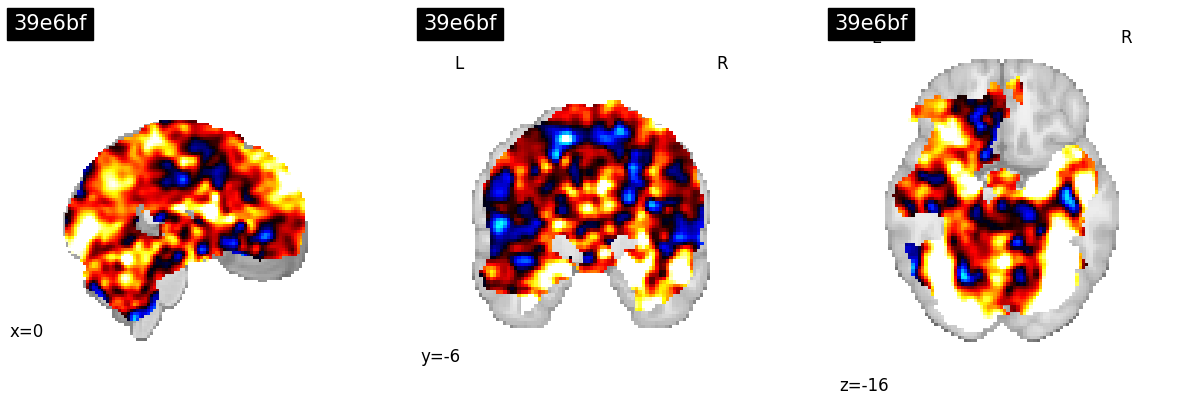

Cluster [2] - Medoids [bd2def9f23886671b22ba8526e6842db4af23b383e9c6b645faa97f8d9d09a14]


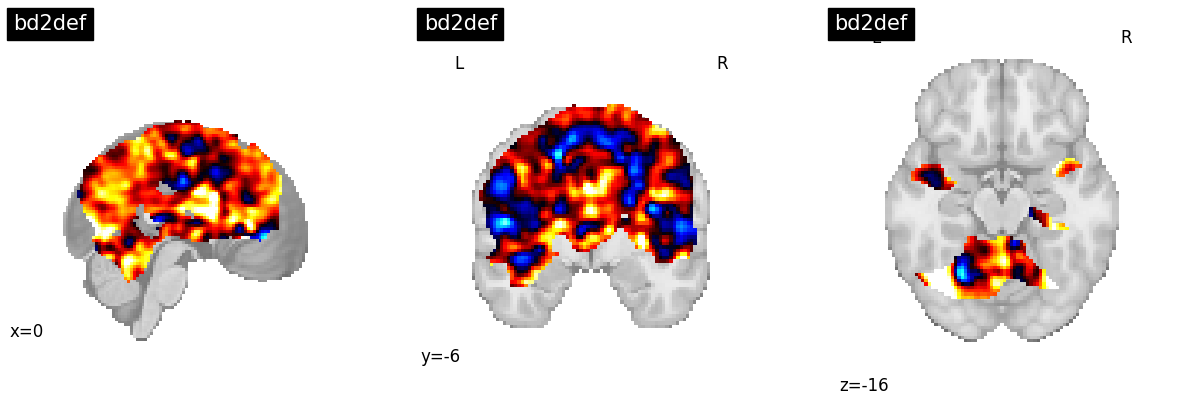

In [11]:
from utils import plot_brain

nb_clusters = 2
medoids = df_results.loc[df_results['clusters'] == nb_clusters, 'medoids'].values[0]
for key, value in medoids.items():
    print(f"Cluster [{key}] - Medoids [{value}]")
    img_path = os.path.join(result_path, value, 'spmT_0001.nii')
    plot_brain(img_path, coords, ref_path=None)

# Filter incorrect configs
- Cluster by 2
- Display medoids
- Eliminate cluster by medoids

In [18]:
excluding_medoids = ['bd2def9f23886671b22ba8526e6842db4af23b383e9c6b645faa97f8d9d09a14']

ds, matrix, Z, clusters = clusterize_hierch(dataset, dataset['id'], 2, corr_func)

clusters_to_exclude = set()
for medoid in excluding_medoids:
    cluster = ds.loc[ds['id'] == medoid, 'cluster'].values
    if len(cluster) > 0:
        clusters_to_exclude.add(cluster[0])

# Step 2: Remove data points from ds that belong to excluded clusters
filtered_dataset = ds[~ds['cluster'].isin(clusters_to_exclude)]

filtered_dataset.head(1000)

,coregistration/source_target/func_on_anat,signal_modeling/nuisance_regressors,motion_correction_realignment/register_to/mean,coregistration/cost_function/normalised_mutual_information,motion_correction_realignment/register_to/first,signal_modelling/temporal_noise_autocorrelation/FAST,spatial_normalization/template/MNI152_linear,spatial_normalization/interpolation/trilinear,spatial_normalization/template/MNI305,spatial_normalization/algorithm/linear,...,spatial_normalization/bias_regularisation/heavy,slice_timing_correction,slice_timing_correction/tool/spm,slice_timing_correction/ref_slice/first,coregistration/source_target/anat_on_func,spatial_normalization/template/MNI152_nonlinear,id,from_ref,from_mean,cluster
734,False,True,True,False,False,False,False,False,False,False,...,0,False,False,False,True,False,ffe5fd155155bb3f5e867f92280f01e4c64d7310b296b7...,0.950332,0.934541,1.0
35,True,True,False,True,True,True,False,False,False,False,...,0,False,False,False,False,False,ffb3044ee8fb8a3008136f0a3e51aecfef30ef43a868f6...,0.946033,0.936825,1.0
28,False,False,True,False,False,True,False,True,False,False,...,0,False,False,False,True,False,ffa7a37a2391fe6330a7bb9cc6ff3ca33a21dad0574818...,0.950332,0.934541,1.0
484,True,True,False,False,True,True,False,False,False,False,...,0,True,True,True,False,False,ff2d946e73ece34f20bc99f71c674a7b445100ae4523fd...,0.830795,0.873024,1.0
546,True,True,True,True,False,False,False,False,False,False,...,0,True,True,False,False,False,ff155109dccd79ee4d9c52131f4117fd56cb938f76c8a2...,0.967853,0.932416,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,False,True,False,False,True,True,False,True,False,False,...,0,False,False,False,True,False,01c1cd262c3b8a05930fdf50e7f65430a636028b06e6de...,0.897895,0.914727,1.0
907,False,False,False,True,True,True,False,True,False,False,...,0,False,False,False,True,False,0109bc5afaf052df332b267b99c88e8525cc4318f990aa...,0.905479,0.917162,1.0
8,False,True,False,True,True,True,False,True,False,False,...,0,False,False,False,True,False,00d978fce6dbfdcae93feb84d97dffa6cf46080035faba...,0.946033,0.936825,1.0
547,False,True,True,True,False,True,False,False,False,False,...,0,True,True,False,True,False,006fb38da122f3aa516a611c695294f915f1508f03fff1...,0.967853,0.932416,1.0


## [Filtered] Cluster by cluster number

In [19]:
import numpy as np
from utils import get_cluster_distance_densities, get_cluster_cophenetic, get_cluster_silhouette, get_davies_bouldin, \
    get_cluster_inertia, get_medoids

all_results = []

nb_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for nb in nb_clusters:
    
    results = dict()
    
    results['clusters'] = nb
    results['threshold'] = None
    
    # cluster on whole dataset
    ds, matrix, Z, clusters = clusterize_hierch(filtered_dataset, filtered_dataset['id'], nb, corr_func)
    
    distance_matrix = 1 - matrix
    densities = get_cluster_distance_densities(distance_matrix.values, clusters.values)
    results['mean_density'] = np.mean(list(densities.values()))
    results['cophenetic'] = get_cluster_cophenetic(Z, distance_matrix.values)
    results['silhouette'] = get_cluster_silhouette(distance_matrix.values, clusters.values)
    results['davies_bouldin'] = get_davies_bouldin(distance_matrix.values, clusters.values)
    results['inertia'] = get_cluster_inertia(distance_matrix.values, clusters.values)
    results['medoids'] = get_medoids(distance_matrix, clusters)
    
    # predict on 70 % train dataset
    merged_results = results | predict_clusters(filtered_dataset, nb)
    all_results.append(merged_results)

df_by_nb = pd.DataFrame(all_results)
df_by_nb.head(10)

,clusters,threshold,mean_density,cophenetic,silhouette,davies_bouldin,inertia,medoids,train_size,accuracy,recall,decision_tree,feature_importances
0,2,None,0.061989,0.975001,0.598294,0.475192,1466.214693,{1: '32b68c5ab087b2ecc92976393a936cb0b95026ad9...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/first': 1.0}
1,3,None,0.045968,0.975001,0.569779,0.383330,529.279912,{1: '9111a94c1a55f876b2a92dfa6466af0879e5b3487...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/hrf/temporal_dispersion_deri...
2,4,None,0.034237,0.975001,0.600931,0.376124,302.995565,{1: '9111a94c1a55f876b2a92dfa6466af0879e5b3487...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/hrf/temporal_dispersion_deri...
3,5,None,0.032796,0.975001,0.473894,0.880829,165.209517,{1: '3e27236adfd6f53460d1fe4c202507e76066eb490...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/mutual_informat...
4,6,None,0.029610,0.975001,0.445247,0.987365,138.617397,{1: '3e27236adfd6f53460d1fe4c202507e76066eb490...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/mutual_informat...
5,7,None,0.027921,0.975001,0.398209,1.195008,119.707613,{1: '3e27236adfd6f53460d1fe4c202507e76066eb490...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/mutual_informat...
6,8,None,0.026670,0.975001,0.420952,1.110986,69.434755,{2: 'efd854c97520d876d11dbbc60711b535a9ac916e7...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/mutual_informat...
7,9,None,0.025071,0.975001,0.447130,1.055703,54.554314,{2: 'efd854c97520d876d11dbbc60711b535a9ac916e7...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/mutual_informat...
8,10,None,0.022966,0.975001,0.469058,0.916645,46.787126,{2: 'efd854c97520d876d11dbbc60711b535a9ac916e7...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/mutual_informat...


## [Filtered] Cluster by threshold

In [20]:
all_results = []

thresholds = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]

for threshold in thresholds:
    results = dict()
    results['threshold'] = threshold
    # cluster on whole dataset
    ds, matrix, Z, clusters = clusterize_hierch(filtered_dataset, filtered_dataset['id'], None, corr_func, threshold)
    results['clusters'] = len(np.unique(clusters.values)) 
    
    distance_matrix = 1 - matrix
    densities = get_cluster_distance_densities(distance_matrix.values, clusters.values)
    results['mean_density'] = np.mean(list(densities.values()))
    results['cophenetic'] = get_cluster_cophenetic(Z, distance_matrix.values)
    results['silhouette'] = get_cluster_silhouette(distance_matrix.values, clusters.values)
    results['davies_bouldin'] = get_davies_bouldin(distance_matrix.values, clusters.values)
    results['inertia'] = get_cluster_inertia(distance_matrix.values, clusters.values)
    results['medoids'] = get_medoids(distance_matrix, clusters)
        
    # predict on 70 % train dataset
    merged_results = results | predict_clusters(filtered_dataset, None, threshold, 0.7)
    all_results.append(merged_results)

df_by_thresh = pd.DataFrame(all_results)
df_by_thresh.head(10)

,threshold,clusters,mean_density,cophenetic,silhouette,davies_bouldin,inertia,medoids,train_size,accuracy,recall,decision_tree,feature_importances
0,0.05,9,0.025071,0.975001,0.447130,1.055703,54.554314,{2: 'efd854c97520d876d11dbbc60711b535a9ac916e7...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/mutual_informat...
1,0.10,4,0.034237,0.975001,0.600931,0.376124,302.995565,{1: '9111a94c1a55f876b2a92dfa6466af0879e5b3487...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/hrf/temporal_dispersion_deri...
2,0.15,2,0.061989,0.975001,0.598294,0.475192,1466.214693,{1: '32b68c5ab087b2ecc92976393a936cb0b95026ad9...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/first': 1.0}
3,0.20,1,0.102081,0.975001,NaN,NaN,7146.467831,{1: '39e6bf7b4ae0f339043540c5c6ef79c40c15d8b4c...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{}
4,0.25,1,0.102081,0.975001,NaN,NaN,7146.467831,{1: '39e6bf7b4ae0f339043540c5c6ef79c40c15d8b4c...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{}
5,0.30,1,0.102081,0.975001,NaN,NaN,7146.467831,{1: '39e6bf7b4ae0f339043540c5c6ef79c40c15d8b4c...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{}
6,0.35,1,0.102081,0.975001,NaN,NaN,7146.467831,{1: '39e6bf7b4ae0f339043540c5c6ef79c40c15d8b4c...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{}


## [Filtered] Print all metrics
- Cophenetic correlation: > 0.75 = good ; < 0.75 = poor
- Silhouette score: -1 = worst ; 1 = best
- Davies-Bouldin index: < 1 = good
- Inertia: lower = tighter

In [21]:
df_results = pd.concat([df_by_nb, df_by_thresh], axis=0)
df_results.head(20)

/home/ymerel/tmp/ipykernel_114376/3439721280.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_by_nb, df_by_thresh], axis=0)


,clusters,threshold,mean_density,cophenetic,silhouette,davies_bouldin,inertia,medoids,train_size,accuracy,recall,decision_tree,feature_importances
0,2,NaN,0.061989,0.975001,0.598294,0.475192,1466.214693,{1: '32b68c5ab087b2ecc92976393a936cb0b95026ad9...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'slice_timing_correction/ref_slice/first': 1.0}
1,3,NaN,0.045968,0.975001,0.569779,0.383330,529.279912,{1: '9111a94c1a55f876b2a92dfa6466af0879e5b3487...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/hrf/temporal_dispersion_deri...
2,4,NaN,0.034237,0.975001,0.600931,0.376124,302.995565,{1: '9111a94c1a55f876b2a92dfa6466af0879e5b3487...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/hrf/temporal_dispersion_deri...
3,5,NaN,0.032796,0.975001,0.473894,0.880829,165.209517,{1: '3e27236adfd6f53460d1fe4c202507e76066eb490...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/mutual_informat...
4,6,NaN,0.029610,0.975001,0.445247,0.987365,138.617397,{1: '3e27236adfd6f53460d1fe4c202507e76066eb490...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/mutual_informat...
5,7,NaN,0.027921,0.975001,0.398209,1.195008,119.707613,{1: '3e27236adfd6f53460d1fe4c202507e76066eb490...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/mutual_informat...
6,8,NaN,0.026670,0.975001,0.420952,1.110986,69.434755,{2: 'efd854c97520d876d11dbbc60711b535a9ac916e7...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/mutual_informat...
7,9,NaN,0.025071,0.975001,0.447130,1.055703,54.554314,{2: 'efd854c97520d876d11dbbc60711b535a9ac916e7...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/mutual_informat...
8,10,NaN,0.022966,0.975001,0.469058,0.916645,46.787126,{2: 'efd854c97520d876d11dbbc60711b535a9ac916e7...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/mutual_informat...
0,9,0.05,0.025071,0.975001,0.447130,1.055703,54.554314,{2: 'efd854c97520d876d11dbbc60711b535a9ac916e7...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/cost_function/mutual_informat...


In [22]:
import seaborn as sb  
    
def plot_value_distributions(dataset):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot for 'from_ref'
    for cluster in labels:
        subset = dataset[dataset['cluster'] == cluster]
        sb.histplot(subset['from_ref'], bins=100, alpha=0.3, label=f'Cluster {cluster}', kde=False, stat='density', ax=axes[0])
        sb.kdeplot(subset['from_ref'], label=f'Cluster {cluster}', linewidth=2, ax=axes[0])
    axes[0].set_title('Value Distribution for from_ref')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot for 'from_mean'
    for cluster in labels:
        subset = dataset[dataset['cluster'] == cluster]
        sb.histplot(subset['from_mean'], bins=100, alpha=0.3, label=f'Cluster {cluster}', kde=False, stat='density', ax=axes[1])
        sb.kdeplot(subset['from_mean'], label=f'Cluster {cluster}', linewidth=2, ax=axes[1])
    axes[1].set_title('Value Distribution for from_mean')
    axes[1].set_xlabel('Value')
    axes[1].set_ylabel('Frequency')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

cluster
1.0    740
2.0    172
3.0     44
4.0     44
Name: count, dtype: int64


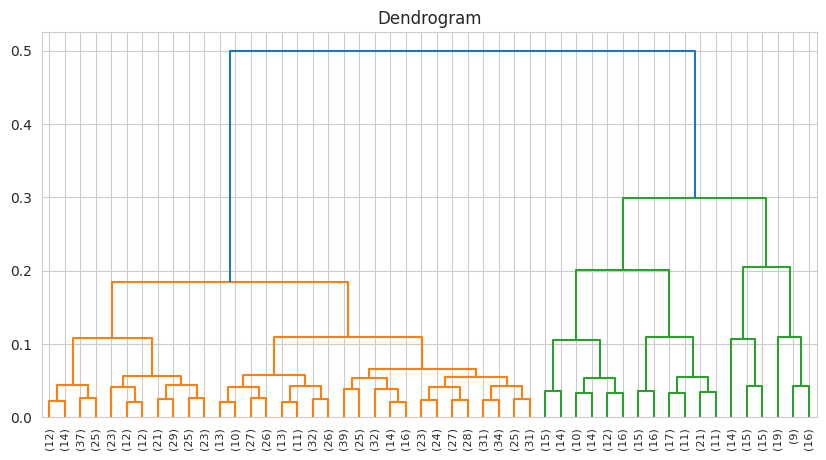

<Figure size 1200x1200 with 0 Axes>

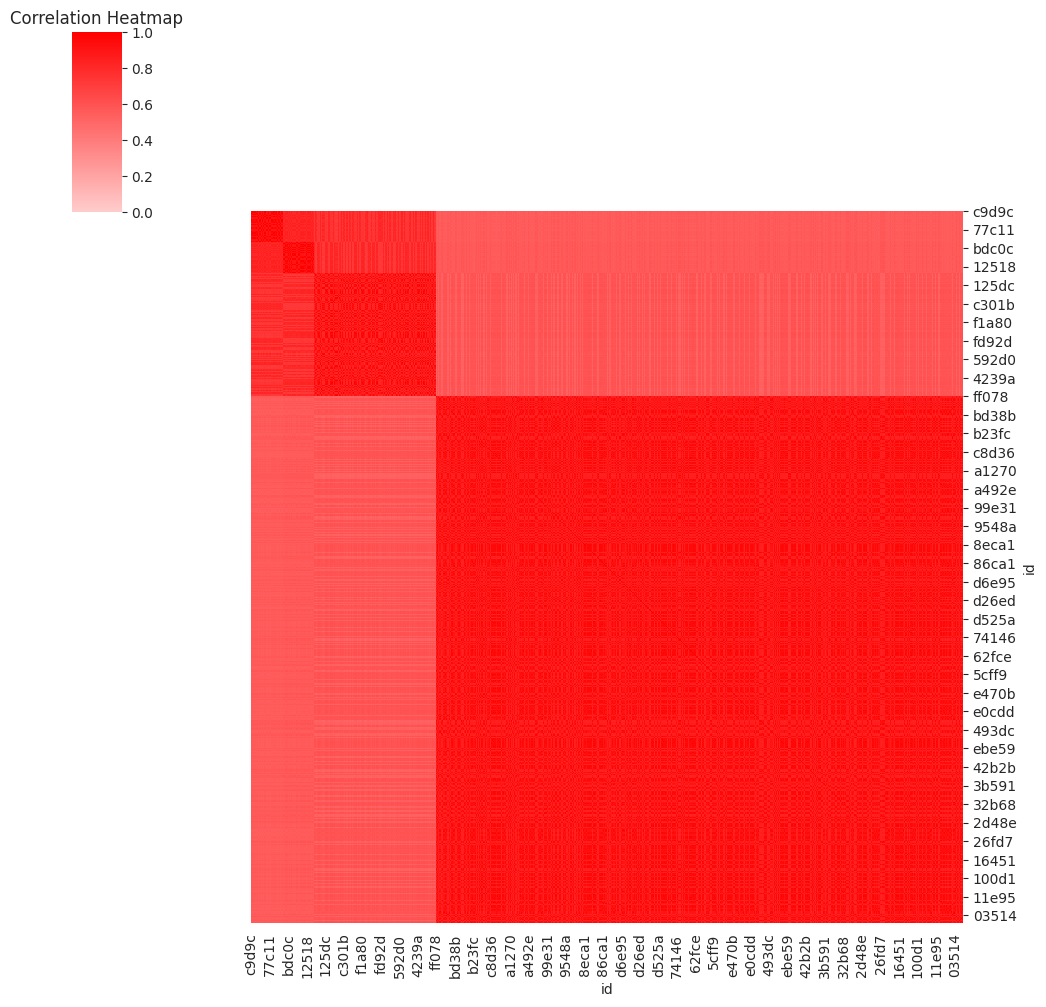

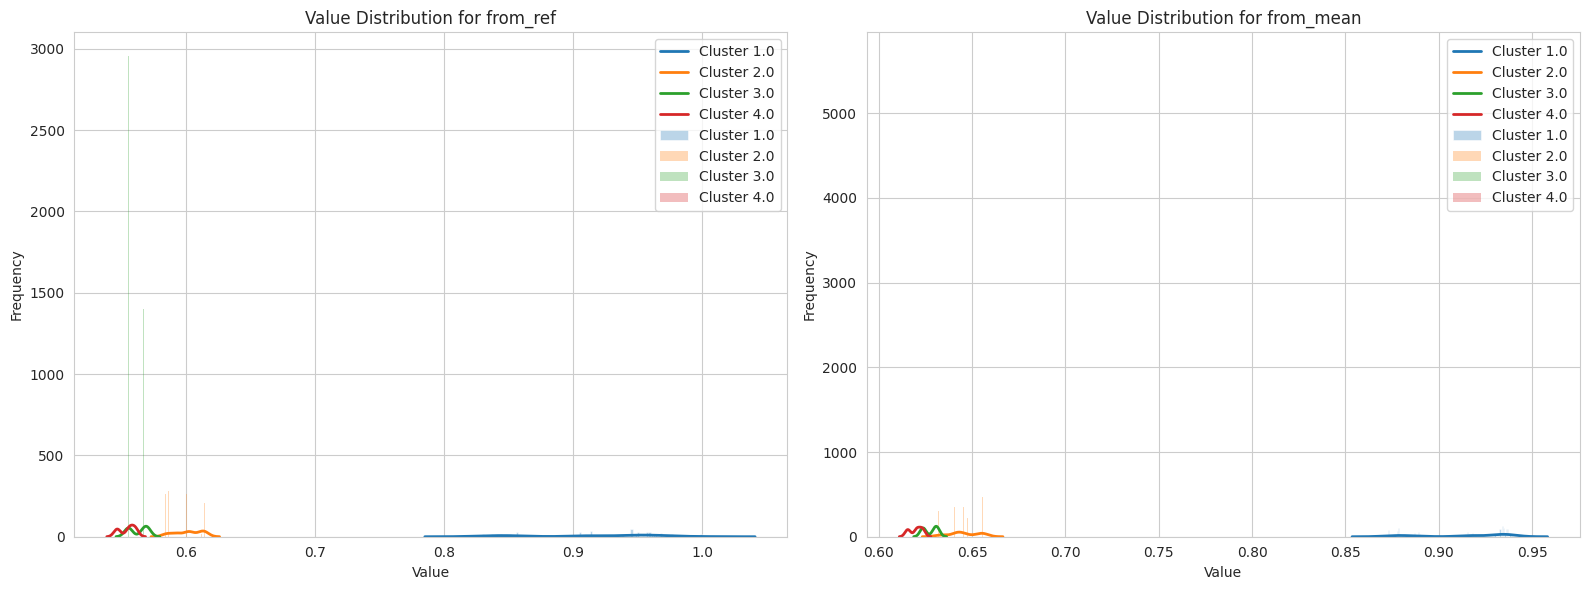

In [26]:

from utils import plot_dendogram, plot_heatmap

nb_clusters = 4

target_vars = [col for col in dataset.columns if col.startswith('from_')]
dataset, matrix, Z, clusters = clusterize_hierch(dataset, dataset["id"], nb_clusters, corr_func, 0.75)

labels = dataset['cluster'].unique()

# reorder matrix by cluster
sorted_index = dataset.sort_values('cluster', ascending=False)['id']
matrix = matrix.reindex(index=sorted_index, columns=sorted_index)
matrix.index = matrix.index.str.slice(0, 5)
matrix.columns = matrix.columns.str.slice(0, 5)

distance_matrix = 1 - matrix

print(f"{dataset['cluster'].value_counts()}")
plot_dendogram(Z)
plot_heatmap(matrix, Z)
plot_value_distributions(dataset)